# COMP4034 — Lecture 3: Motion Control & Robot Behaviours

**Interactive instructor notebook for Lecture 3**

Includes:
1. **Motion Control**
- Twist publish demo
- PID parameters demo 
2. **Behaviour-Based Robotics** 
- Interactive Braitenberg Vehicles
- FSM with live Gazebo interaction

Runs inside the **UON‑CS robotlab simulation container** with ROS2 Humble.


## Setup & Safety
- Ensure your environment is correctly sourced (`source /opt/ros/humble/setup.bash`).
- Gazebo / TurtleBot3 simulation should be running for Twist demos. (`ros2 launch turtlebot3_gazebo turtlebot3_world.launch.py`)
- Use small speeds (≤ 0.3 m/s linear, ≤ 0.5 rad/s angular).


## Demo 1 – Publish `Twist` commands
Let's publish a simple velocity command to `/cmd_vel` within the `gazebo_world` environment. 

In [1]:
try:
    import rclpy
    import time
    from geometry_msgs.msg import Twist
except Exception as e:
    print("ROS2 libraries not available:", e)
    
else:
    def publish_twist_once(linear_x=0.2, angular_z=0):

        rclpy.init()
    
        node = rclpy.create_node('demo_twist')
        pub = node.create_publisher(Twist, '/cmd_vel', 10)
        
        msg = Twist()
        msg.linear.x=linear_x
        msg.angular.z=angular_z
        
        pub.publish(msg)
        node.get_logger().info(f'Published linear={linear_x}, angular={angular_z}')
        
        time.sleep(0.2)
    
        node.destroy_node(); 
        rclpy.shutdown()
        
    publish_twist_once()

AssertionError: The 'z' field must be of type 'float'

In [ ]:
# Stop the robot safely
try:
    rclpy.init()
    node = rclpy.create_node('demo_stop')
    pub = node.create_publisher(Twist, '/cmd_vel', 10)
    
    msg = Twist()
    pub.publish(msg)
    
    node.get_logger().info('Stop command published')
    node.destroy_node()
    rclpy.shutdown()

except Exception as e:
    print('Not running in ROS 2 container:', e)

You see that the `publish_twist_once` sends one `Twist` message, but your robot keeps on moving! Why?

- `/cmd_vel` is a velocity command topic, it is not a position or trajectory command.
- In practice, the robot’s local controller keeps executing the last received velocity until it receives a new one.
- When you publish once (e.g. `linear.x = 0.2`), the robot starts moving at 0.2 m/s and will continue indefinitely... unless:
    - You publish another `Twist` with zeros
    - The controller’s internal timeout expires: some have a built-in 0.5–1 s stop timeout, but many simulations don’t!

So your single publish sets a persistent motion command.

In [2]:
# Now try issuing the Twish in a loop
try:
    import rclpy
    import time
    from geometry_msgs.msg import Twist
except Exception as e:
    print("ROS2 libraries not available:", e)
    
else:
    def publish_twist_continuous(linear_x=0.2, angular_z=0.3):
        try: 
            rclpy.init()
        
            node = rclpy.create_node('demo_twist')
            pub = node.create_publisher(Twist, '/cmd_vel', 10)
            
            msg = Twist()
            msg.linear.x=linear_x
            msg.angular.z=angular_z
            
            pub.publish(msg)
            node.get_logger().info(f'Published linear={linear_x}, angular={angular_z}')
            
            while rclpy.ok():
                pub.publish(msg)
                time.sleep(0.1)
    
        except KeyboardInterrupt:
            print("KeyboardInterrupt detected — stopping robot.")
            pub.publish(Twist())
        finally:
            node.destroy_node(); 
            rclpy.shutdown()
        
    publish_twist_continuous()

UnboundLocalError: local variable 'node' referenced before assignment

**What the continuous publisher adds?**

The continuous version (looping at 10 Hz) mimics what a real controller does: it keeps re-issuing velocity commands so that the base firmware never times out or drifts.

It’s safer and closer to real robot behaviour:
- You can stop any time (interrupt cell → stop message).
- If communication drops, the robot’s firmware usually stops automatically after a timeout.

## Demo 2 – PID Control Simulation
Explore rise time, overshoot, and steady‑state error.

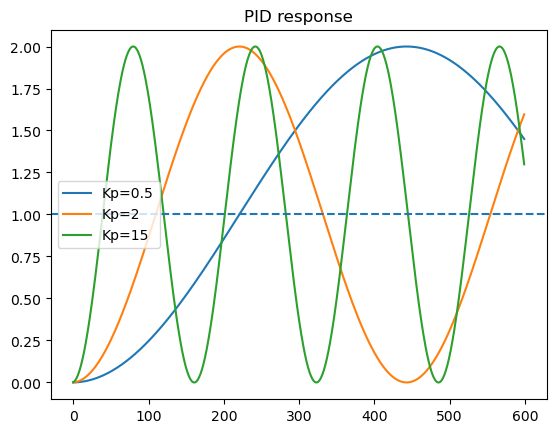

In [3]:
import numpy as np, matplotlib.pyplot as plt

def pid_sim(Kp=5.0,Ki=0,Kd=0,steps=600,dt=0.01):
    x=v=i=e_prev=0
    out=[] 
    
    for _ in range(steps):
        e = 1-x
        i += e*dt
        d = (e-e_prev)/dt
        
        u = Kp*e + Ki*i + Kd*d
        
        v += u*dt
        x += v*dt
        out.append(x)
        
        e_prev=e
        
    return np.array(out)

plt.figure(); 
for Kp in [0.5,2,15]:
    plt.plot(pid_sim(Kp=Kp),label=f'Kp={Kp}')

plt.legend()
plt.axhline(1,ls='--')
plt.title('PID response')
plt.show()


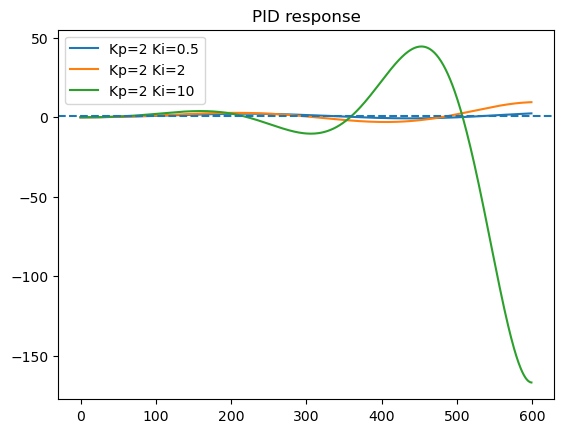

In [4]:
# Change Ki
plt.figure(); 

for Ki in [0.5,2,10]:
    plt.plot(pid_sim(Kp=2, Ki=Ki, Kd=0),label=f'Kp=2 Ki={Ki}')        
    
plt.legend()
plt.axhline(1,ls='--')
plt.title('PID response')
plt.show()

In [ ]:
# Change Kd
plt.figure(); 

for Kd in [0.1,1,5,8]:
    plt.plot(pid_sim(Kp=2, Ki=0.5, Kd=Kd),label=f'Kp=2 Ki=0.5 Kd={Kd}')
  
plt.legend()
plt.axhline(1,ls='--')
plt.title('PID response')
plt.show()

# Behaviour‑Based Robotics
We now build on motion control to create **emergent robot behaviours**.

## Demo 3 – Braitenberg Vehicle Simulation

This demo illustrates how simple sensor–motor wiring can produce lifelike behaviour.
Each vehicle has two light sensors (left/right) controlling two motors.
Different connection types create different behavioural patterns:
- **Fear** — direct excitatory wiring (moves away from light)
- **Aggression** — crossed excitatory (moves toward light)
- **Love** — crossed inhibitory (approaches and slows near light)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Choose behaviour: 'fear', 'aggression', 'love'
mode = 'fear'

# Simulation parameters
dt = 0.05
steps = 400

sensor_offset = 0.25 # distance from center
sensor_angle = np.pi / 3 # 60 degrees
light = np.array([1.5, 0.7])

# Vehicle initial state
# Start with a slight heading offset to break symmetry
x, y, th = -1.5, -0.5, 0.15
traj = [(x, y)]

# sensor mapping helper
def sensor_positions(x, y, th):
    left = np.array([x + sensor_offset*np.cos(th + sensor_angle),
                     y + sensor_offset*np.sin(th + sensor_angle)])
    right = np.array([x + sensor_offset*np.cos(th - sensor_angle),
                      y + sensor_offset*np.sin(th - sensor_angle)])
    return left, right

# could be a better sensor model
def sensors_to_intensity(left_pos, right_pos):
    dL = np.linalg.norm(light - left_pos)
    dR = np.linalg.norm(light - right_pos)
    # inverse-square + nonlinearity
    L = np.tanh(6.0 / (dL**2 + 0.05))
    R = np.tanh(6.0 / (dR**2 + 0.05))
    return L, R


# Make the connections for enacting the behaviours
def braitenberg_step(x, y, th, mode):
    Lpos, Rpos = sensor_positions(x, y, th)
    dL, dR = np.linalg.norm(light - Lpos), np.linalg.norm(light - Rpos)
    # higher gain gives stronger light gradient
    Ls, Rs = 2.0 / (dL**2 + 0.2), 2.0 / (dR**2 + 0.2)
    
    #Ls, Rs = sensors_to_intensity(Lpos, Rpos)


    # Behaviour-specific target forward and turn gains
    if mode == 'fear':            # direct excitatory
        vL, vR = Ls, Rs
    elif mode == 'aggression':    # crossed excitatory
        vL, vR = Rs, Ls
    elif mode == 'love':          # direct inhibitory
        vL, vR = 1 - Ls, 1 - Rs
    

    # differential drive
    v = (vL + vR) / 2.0
    w = (vR - vL) / 0.5  # positive = turn left
    
    th += w * dt
    x += v * np.cos(th) * dt
    y += v * np.sin(th) * dt
    
    if _ < 10:  # print first few iterations
        print(f"{mode:>11s}: vL={vL:.3f} vR={vR:.3f}  v={v:.3f}  w={w:.3f}")
    
    return x, y, th

# Precompute trajectory
for _ in range(steps):
    x, y, th = braitenberg_step(x, y, th, mode)
    traj.append((x, y))
    
traj = np.array(traj)

In [ ]:
# --- animation ---
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(-2, 2)
ax.set_ylim(-1.5, 2)
ax.set_title(f"Braitenberg Vehicle – {mode.capitalize()}")
ax.plot(light[0], light[1], 'yo', markersize=12, label='Light')
path_line, = ax.plot([], [], 'r--')
robot_dot, = ax.plot([], [], 'ro', markersize=8)
ax.legend()

def init():
    path_line.set_data([], [])
    robot_dot.set_data([], [])
    return path_line, robot_dot

def update(i):
    xs, ys = traj[:i, 0], traj[:i, 1]
    path_line.set_data(xs, ys)
    robot_dot.set_data(traj[i, 0], traj[i, 1])
    return path_line, robot_dot

ani = FuncAnimation(fig, update, frames=len(traj),
                    init_func=init, interval=40, blit=True, repeat=False)
HTML(ani.to_jshtml())

ani.save(f"braitenberg_{mode}.mp4", writer='ffmpeg', fps=25)


## Demo 4 – Simple Finite State Machine

We will use ROS 2 topics:

- Subscribe to /scan (LiDAR)
- Publish to /cmd_vel
- Simple thresholds for obstacle detection in front sector (e.g., any range < 0.5 m)

In [5]:
import rclpy, time
from rclpy.node import Node
from sensor_msgs.msg import LaserScan
from geometry_msgs.msg import Twist

class FSMNode(Node):
    def __init__(self):
        super().__init__('fsm_demo')
        self.state = 'EXPLORE'
        self.lidar_sub = self.create_subscription(LaserScan, '/scan', self.lidar_cb, 10)
        self.cmd_pub = self.create_publisher(Twist, '/cmd_vel', 10)
        
        self.obstacle_ahead = False
        self.timer = self.create_timer(0.1, self.loop)
        self.start_time = self.get_clock().now()

    def lidar_cb(self, msg):
        # front 30° cone
        mid = len(msg.ranges)//2
        front = msg.ranges[mid-15:mid+15]
        self.obstacle_ahead = any(r < 0.5 for r in front if r > 0.01)
        

    def loop(self):
        msg = Twist()
        if self.state == 'EXPLORE':
            msg.linear.x = 0.2
            if self.obstacle_ahead:
                self.transition('AVOID')
        elif self.state == 'AVOID':
            msg.angular.z = 0.6
            if not self.obstacle_ahead:
                self.transition('STOP')
        elif self.state == 'STOP':
            msg.linear.x = 0.0
        self.cmd_pub.publish(msg)

    def transition(self, new_state):
        self.get_logger().info(f'{self.state} → {new_state}')
        self.state = new_state

def run_fsm():
    rclpy.init()
    node = FSMNode()
    try:
        rclpy.spin(node)
    except KeyboardInterrupt:
        node.get_logger().info('Shutting down FSM...')
    finally:
        node.cmd_pub.publish(Twist())  # stop
        node.destroy_node()
        rclpy.shutdown()

run_fsm()

RuntimeError: Context.init() must only be called once